In [5]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential, Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [13]:
from PIL import Image, ImageEnhance
import os
import numpy as np

# Define input and output directories
input_dir = r"C:\Users\MSI\Desktop\4DS1\Test101OCR\dataset_classification\Prescriptions"
output_dir = r"C:\Users\MSI\Desktop\Test101OCR\preprocessed_dataset\Prescriptions"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define target CNN-friendly size
TARGET_SIZE = (512, 512)  # Keeps enough detail for OCR & CNN

# Function to preprocess images
def preprocess_image(image_path, output_path):
    # Load image
    image = Image.open(image_path)
    
    # Convert to grayscale
    gray_image = image.convert("L")

    # Enhance sharpness before resizing
    enhancer = ImageEnhance.Sharpness(gray_image)
    sharp_image = enhancer.enhance(2.0)  # Adjust the factor as needed

    # Resize using LANCZOS filter for high-quality downsampling
    resized_image = sharp_image.resize(TARGET_SIZE, Image.LANCZOS)

    # Enhance sharpness after resizing
    enhancer = ImageEnhance.Sharpness(resized_image)
    final_image = enhancer.enhance(1.5)  # Adjust the factor as needed

    # Save processed image with high quality
    final_image.save(output_path, dpi=(300, 300), quality=95)  # Adjust DPI and quality as needed

# Process all images in the folder
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        preprocess_image(input_path, output_path)

print(f"✅ Image preprocessing completed. Check the folder: {output_dir}")

✅ Image preprocessing completed. Check the folder: C:\Users\MSI\Desktop\Test101OCR\preprocessed_dataset\Prescriptions


✅ Dataset split into Train & Validation!
Found 3171 images belonging to 5 classes.
Found 788 images belonging to 5 classes.


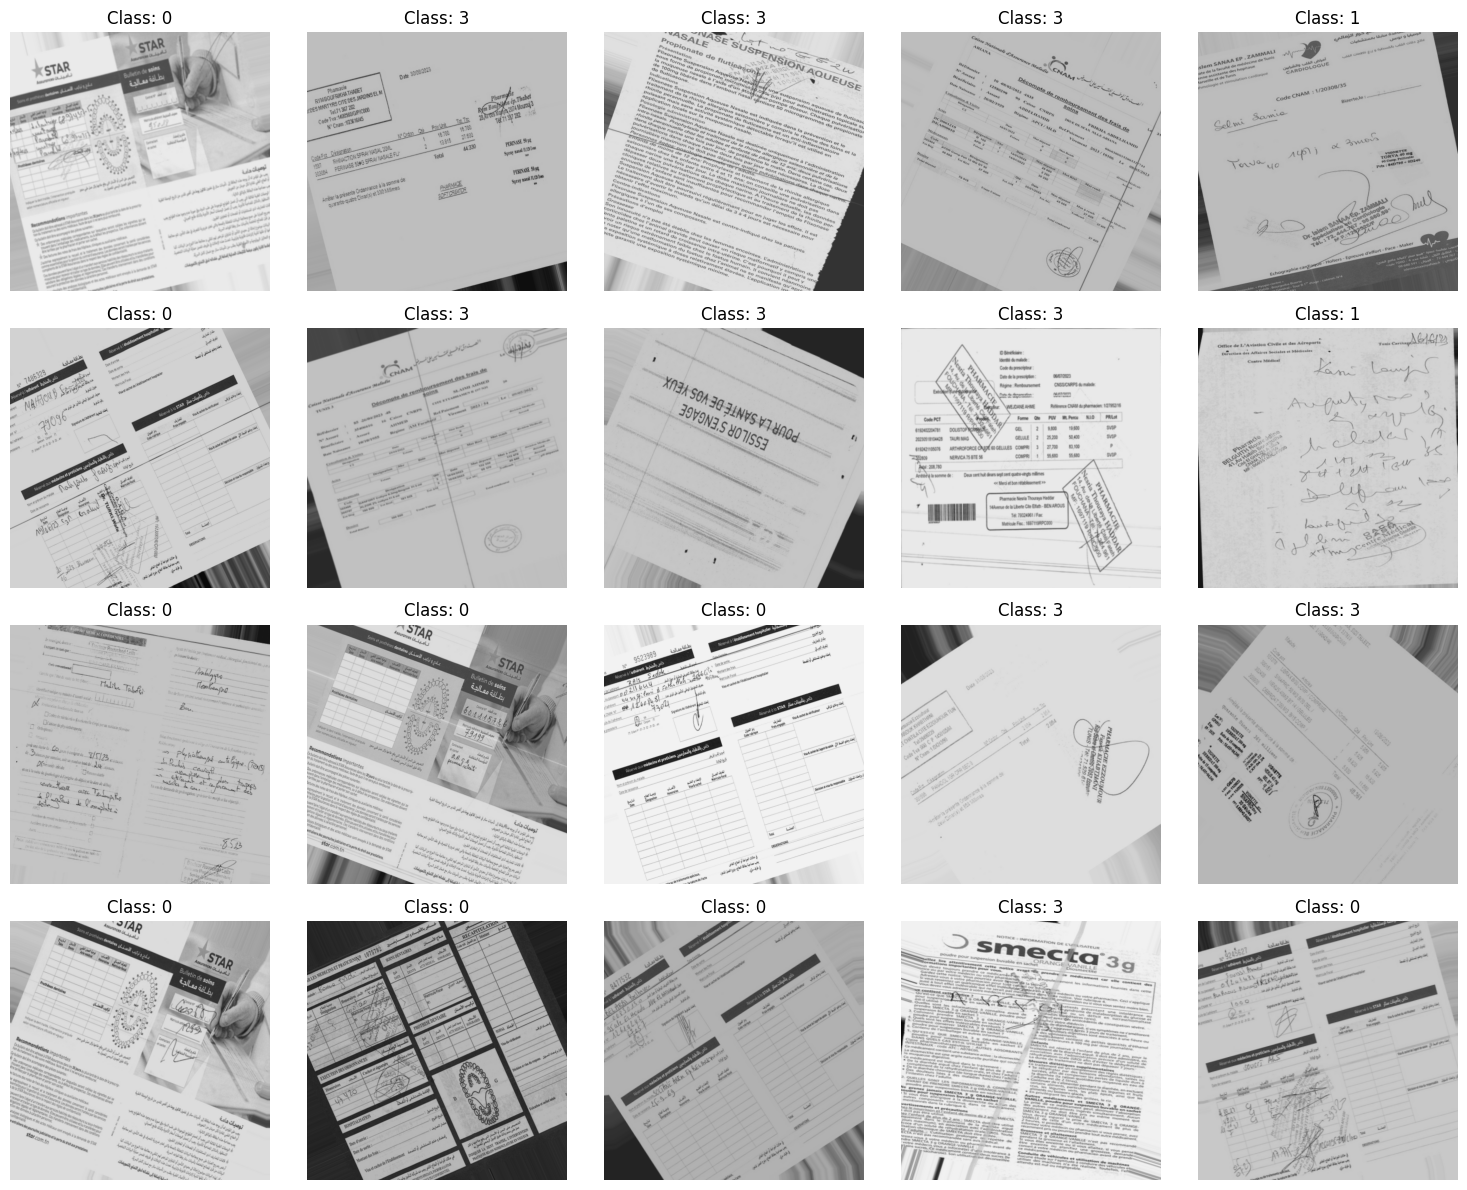

In [15]:
import cv2
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
import os
import shutil

# Function to apply random brightness and contrast adjustments
def adjust_lighting(image):
    pil_image = Image.fromarray(image)
    brightness_factor = random.uniform(0.7, 1.0)
    contrast_factor = random.uniform(0.7, 1.0)

    # Apply brightness adjustment
    enhancer = ImageEnhance.Brightness(pil_image)
    pil_image = enhancer.enhance(brightness_factor)

    # Apply contrast adjustment
    enhancer = ImageEnhance.Contrast(pil_image)
    pil_image = enhancer.enhance(contrast_factor)

    return np.array(pil_image)

# Function to add slight Gaussian blur
def add_gaussian_blur(img):
    return cv2.GaussianBlur(img, (3, 3), 0)

# Function to add minor handshake blur
def add_handshake_blur(img, kernel_size=2):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    return cv2.filter2D(img, -1, kernel)

# Function to rotate image slightly
def rotate_image(img, angle=30):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, rotation_matrix, (w, h), borderMode=cv2.BORDER_REPLICATE)

# Custom preprocessing function (ONLY for training images)
def custom_preprocessing(img):
    img = img_to_array(img).astype(np.uint8)

    # Apply random brightness and contrast adjustments
    img = adjust_lighting(img)

    # Apply blur with a 20% probability
    if random.random() > 0.8:
        img = add_gaussian_blur(img)
    elif random.random() > 0.8:
        img = add_handshake_blur(img)

    # Apply slight rotation with a 50% probability
    if random.random() > 0.5:
        angle = random.uniform(-30, 30)
        img = rotate_image(img, angle)

    # Normalize back to [0, 1]
    img = img.astype(np.float32) / 255.0
    return img

# ========================
# 🔹 SPLIT DATASET: 80% TRAIN, 20% VALIDATION
# ========================
input_dir = r"C:\Users\MSI\Desktop\Test101OCR\preprocessed_dataset"
train_dir = r"C:\Users\MSI\Desktop\Test101OCR\train_dataset"
val_dir = r"C:\Users\MSI\Desktop\Test101OCR\validation_dataset"

# Ensure directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split ratio
split_ratio = 0.2  # 20% validation

# Move files to train/validation directories
for class_folder in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_folder)
    train_class_path = os.path.join(train_dir, class_folder)
    val_class_path = os.path.join(val_dir, class_folder)

    if os.path.isdir(class_path):
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)

        # Get all image files
        images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))]

        # Shuffle and split
        val_size = int(len(images) * split_ratio)
        val_images = random.sample(images, val_size)

        # Move validation images
        for img in val_images:
            shutil.move(os.path.join(class_path, img), os.path.join(val_class_path, img))

        # Move remaining to train
        for img in os.listdir(class_path):
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_path, img))

print("✅ Dataset split into Train & Validation!")

# ========================
# 🔹 DATA GENERATORS
# ========================

# Augmentation for TRAINING (with custom preprocessing)
train_datagen = ImageDataGenerator(
    rotation_range=30,
    brightness_range=[0.98, 1.02],
    preprocessing_function=custom_preprocessing  # Apply augmentation only on train
)

# NO AUGMENTATION for VALIDATION
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Just normalization

# Load train images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

# Load validation images
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do NOT shuffle validation data
)

# ========================
# 🔹 DISPLAY AUGMENTED TRAINING IMAGES
# ========================
batch = next(train_generator)
images, labels = batch
num_images = 20
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i in range(num_images):
    axes[i].imshow((images[i] * 255).astype(np.uint8))  # Convert back to 0-255 for display
    axes[i].axis('off')
    axes[i].set_title(f"Class: {np.argmax(labels[i])}")

plt.tight_layout()
plt.show()


In [16]:
import numpy as np
from sklearn.utils import class_weight

# Get the class labels from the generator
labels = train_generator.classes

# Print class distribution
unique_classes, class_counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(labels), y=labels
)
class_weights = dict(enumerate(class_weights))

# Print class weights
print("Class weights:")
for cls, weight in class_weights.items():
    print(f"Class {cls}: {weight:.2f}")

Class distribution:
Class 0: 1226 samples
Class 1: 481 samples
Class 3: 1464 samples
Class weights:
Class 0: 0.86
Class 1: 2.20
Class 2: 0.72


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# The CNN model for document classification per type
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Updated to match train_generator
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True  
)

# Define learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=2,          
    min_lr=1e-6          
)

# Train the model
history = model.fit(
    train_generator,
    epochs=8,
    validation_data=validation_generator,  # ✅ Corrected: Use validation_generator instead of validation_dir
    class_weight=class_weights if 'class_weights' in locals() else None,  # ✅ Only use if defined
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/8


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 25088, but received input with shape (None, 492032)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 512, 512, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
#evaluate the model: accuracy, confusion matrix, f1, precision..
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9543 - loss: 0.1302
Validation Loss: 0.20663800835609436
Validation Accuracy: 0.9276649951934814


In [ ]:
model.save('model.h5')

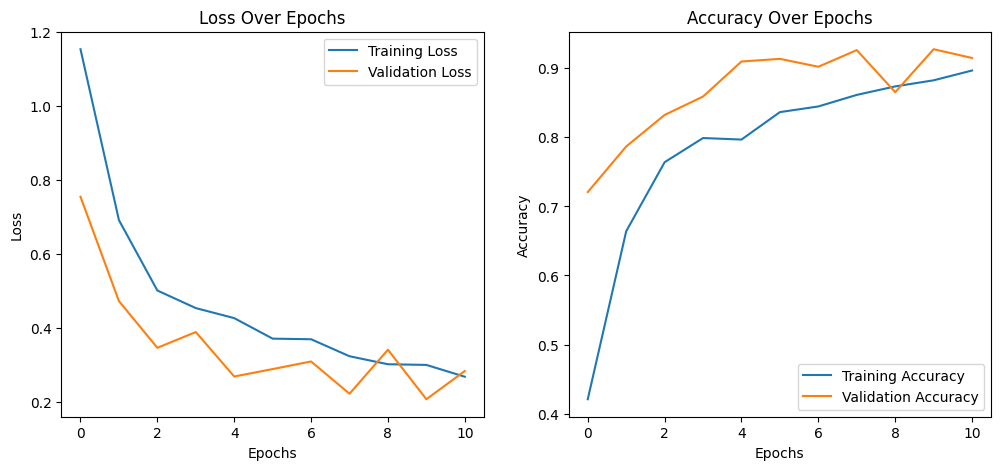

In [ ]:
#plot the loss and accuracy for validation set 
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")

    plt.show()

plot_training_history(history)

In [ ]:
# # Hyperparameter tuning function
# def build_model(hp):
#     model = Sequential()

#     model.add(Conv2D(
#         filters=hp.Int('filters_1', min_value=32, max_value=512, step=32), 
#         kernel_size=(3, 3), 
#         activation='relu', 
#         input_shape=(150, 150, 3)
#     ))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(
#         filters=hp.Int('filters_2', min_value=64, max_value=256, step=64), 
#         kernel_size=(3, 3), 
#         activation='relu'
#     ))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

#     model.add(Conv2D(
#         filters=hp.Int('filters_3', min_value=512, max_value=512, step=512), 
#         kernel_size=(3, 3), 
#         activation='relu'
#     ))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

#     model.add(Flatten())

#     model.add(Dense(
#         units=hp.Int('units', min_value=512, max_value=512, step=512), 
#         activation='relu'
#     ))
#     model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

#     model.add(Dense(2, activation='softmax'))

#     model.compile(
#         optimizer=Adam(
#             learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
#         ),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

In [ ]:
# import keras_tuner as kt
# # Create the tuner with the specified search space
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_loss',  
#     max_epochs=11,         
#     hyperband_iterations=2,  # How many times to explore the search space
#     directory='my_dir',     # Directory to save logs and results
#     project_name='document_classification'
# )

# tuner.search(train_generator, validation_data=validation_generator, epochs=11, class_weight=class_weights)


In [ ]:
# best_model = tuner.get_best_models(num_models=1)[0]

# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(best_hyperparameters.values)

# history = best_model.fit(
#     train_generator,
#     epochs=11,
#     validation_data=validation_generator,
#     class_weight=class_weights,
#     callbacks=[early_stopping, lr_scheduler]
# )


In [ ]:
#function to predict the class of one picture 
def predict_image_class(model, img_path, class_indices, threshold=0.7, target_size=(512, 512)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    predictions = model.predict(img_array)

    class_index = np.argmax(predictions, axis=1)[0]

    class_labels = list(class_indices.keys())

    predicted_class = class_labels[class_index]

    predicted_prob = predictions[0][class_index]
 

    return predicted_class, predicted_prob

In [ ]:
from tensorflow.keras.preprocessing import image  # ✅ Import the missing module
import numpy as np

def predict_image_class(model, img_path, class_indices, threshold=0.7, target_size=(512, 512)):  # Match target size
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[list(class_indices.values()).index(predicted_index)]
    predicted_prob = predictions[0][predicted_index]

    return predicted_class, predicted_prob

# ✅ Correctly call the function
img_path = r"C:\Users\MSI\Downloads\ee6e0ce4-c52e-46b8-b381-ad479ecd681b.jpeg"
predicted_class, predicted_prob = predict_image_class(model, img_path, train_generator.class_indices)

print(f'Predicted Class: {predicted_class}')
print(f'Prediction Probability: {predicted_prob:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Class: Processed_Others
Prediction Probability: 0.7283


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def display_images_and_predict(model, test_folder_path, class_names, threshold=0.7):
    """
    Display images from the test folder and make predictions using the model.
    """
    for img_name in os.listdir(test_folder_path):
        img_path = os.path.join(test_folder_path, img_name)
        
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(512, 512))  # Resize to (150, 150)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize to [0, 1]
        
        # Make predictions
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_prob = predictions[0][predicted_class_idx]
        
        # Display the image and prediction
        plt.imshow(img)
        plt.axis('off')
        if predicted_prob >= threshold:
            plt.title(f"Predicted: {class_names[predicted_class_idx]} ({predicted_prob:.2f})")
        else:
            plt.title("Uncertain Prediction")
        plt.show()

In [ ]:
class_names = list(train_generator.class_indices.keys())
threshold_value = 0.7  
test_folder_path = r"C:\Users\MSI\Desktop\Test101OCR\test_dataset" # Path to test images
display_images_and_predict(model, test_folder_path, class_names, threshold=threshold_value)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/dense_2_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\MSI\AppData\Local\Temp\ipykernel_15992\1468959644.py", line 4, in <module>

  File "C:\Users\MSI\AppData\Local\Temp\ipykernel_15992\2483467556.py", line 11, in display_images_and_predict

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 562, in predict

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 259, in one_step_on_data_distributed

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 249, in one_step_on_data

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in predict_step

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 908, in __call__

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 637, in call

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 908, in __call__

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py", line 148, in call

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\activations\activations.py", line 47, in relu

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\activations\activations.py", line 101, in static_call

  File "c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [1,492032], In[1]: [25088,512]
	 [[{{node sequential_1_1/dense_2_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_24112]

In [ ]:
# test_folder_path = 'test_folder'
# class_names = list(train_generator.class_indices.keys())
# threshold_value = 0.7  
# display_images_and_predict(best_model, test_folder_path, class_names, threshold=threshold_value)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
Confusion Matrix:
[[294  10   1]
 [  2 326  36]
 [  0   8 111]]
Classification Report:
                             precision    recall  f1-score   support

Processed_Medical_Care_Form       0.99      0.96      0.98       305
           Processed_Others       0.95      0.90      0.92       364
    Processed_Prescriptions       0.75      0.93      0.83       119

                   accuracy                           0.93       788
                  macro avg       0.90      0.93      0.91       788
               weighted avg       0.94      0.93      0.93       788



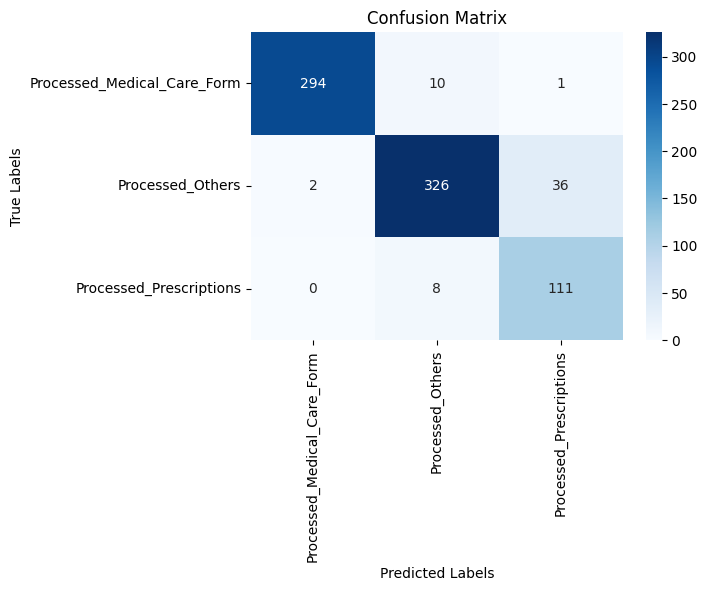

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(validation_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=validation_generator.class_indices.keys(), 
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()